In [1]:
# Import all necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, precision_score, recall_score 
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
import seaborn as sns

In [2]:
# Reset PN-sequence generator.
seed = 42
np.random.seed(seed)

### Criando exemplos de 3 classes.

In [3]:
# Define the number of different classes.
numberOfClasses = 3

# Number of examples.
N = 1000

# Create a 3-class dataset for classification.
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=N, centers=centers, random_state=seed)

### Plotando as 3 classes.

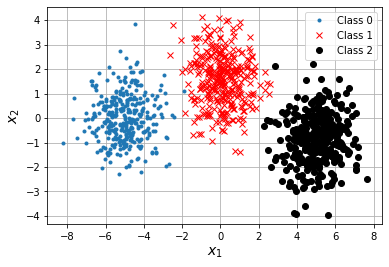

In [4]:
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)
idx2 = np.argwhere(y == 2)

plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Dividindo o conjunto total em conjuntos para treinamento e validação.

In [5]:
# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

### Criando as matrizes de atributo de treinamento e validação.

In [6]:
X_train = np.c_[np.ones((len(y_train), 1)), X_train]

X_test = np.c_[np.ones((len(y_test), 1)), X_test]

### Instanciando e treinando o classificador.

**OBS**: Instanciamos um objeto da classe `LogisticRegression` para operar como regressor softmax configurando o parâmetro `multi_class` como `'multinomial'`.

In [7]:
# Instantiate LogisticRegression object for multi-class case.
model = LogisticRegression(multi_class='multinomial', random_state=seed)

# Train model.
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=42)

### Plotando as regiões de decisão.

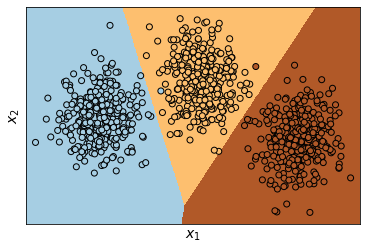

In [8]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

### Plotando a matriz de confusão.

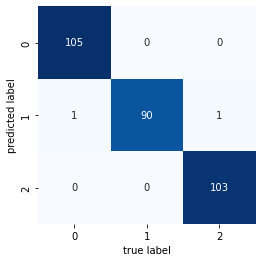

In [9]:
# Predict.
y_pred = model.predict(X_test)

# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(numberOfClasses), yticklabels=range(numberOfClasses), cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Plotando as curvas ROC.

**Observações**: 

+ Como temos 3 classes, para plotar as curvas ROC, usamos a abordagem *um-contra-o-resto* para criar 3 curvas: 
    + classe 0 (+) contra classes 1 e 2 (-).
    + classe 1 (+) contra classes 0 e 2 (-).
    + classe 2 (+) contra classes 0 e 1 (-).

+ Compara-se o desempenho do classificador com o desempenho de um classificador puramente aleatório. 
+ No caso abaixo, o classificador tem como saída a classe 0 ou 1 com a mesma probabilidade, ou seja, 50%.

In [10]:
# Binarize the test targets.
# Converte vetor de entrada na codificação one-hot.
y_test_bin = label_binarize(y_test, classes=range(numberOfClasses))

print('Input values:\n', y_test[0:10])
print('Output shape:', y_test_bin.shape)
print('Output values:\n', y_test_bin[0:10,:])

Input values:
 [0 0 2 0 2 1 1 2 1 0]
Output shape: (300, 3)
Output values:
 [[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]


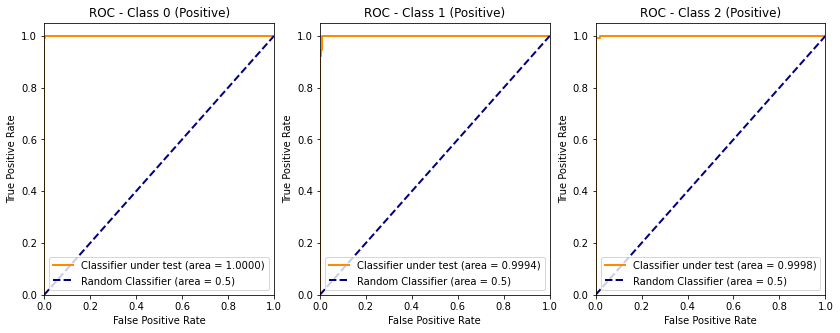

In [11]:
# Getting the probabilities for each class.
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(14, 5))
lw = 2
for i in range(numberOfClasses):
    # Calculating ROC curve and ROC AUC.
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Plotting ROC curve for class i.
    ax = plt.subplot(1, numberOfClasses, i + 1)
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='Classifier under test (area = %1.4f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Classifier (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Class '+str(i)+' (Positive)')
    plt.legend(loc="lower right")

plt.show()

### Relatório mostrando as principais métricas de classificação.

In [12]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9906    0.9953       106
           1     0.9783    1.0000    0.9890        90
           2     1.0000    0.9904    0.9952       104

    accuracy                         0.9933       300
   macro avg     0.9928    0.9937    0.9931       300
weighted avg     0.9935    0.9933    0.9934       300



### Calculando as métricas individualmente.

In [13]:
acc = accuracy_score(y_test, y_pred)

print('Accuracy of Logistic Regression model is: %1.3f' % (acc*100))

Accuracy of Logistic Regression model is: 99.333


In [14]:
precision = precision_score(y_test, y_pred, average=None)

print('Precision score is:', precision)

Precision score is: [1.         0.97826087 1.        ]


In [15]:
recall = recall_score(y_test, y_pred, average=None)

print('Recall is:', recall)

Recall is: [0.99056604 1.         0.99038462]


In [16]:
f1 = f1_score(y_test, y_pred, average=None)

print('F1-score is:', f1)

F1-score is: [0.99526066 0.98901099 0.99516908]
